In [483]:
!pip install -q celluloid plotly seaborn

In [484]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from IPython.display import HTML
from celluloid import Camera
from scipy.integrate import odeint
import seaborn as sns
sns.set() # Cambiando el estilo de las gráficas

from sympy import (
    symbols, Function, diff, sin, cos, simplify, Rational, Eq, Matrix,
    Derivative, solve, lambdify,  Mul
)

# Mecánica Celeste
## 2023-II
## Set de Problemas No 4: Formalismos Lagrangiano y Hamiltoniano

Definamos algunas funciones utiles a través de la solución de los diferentes problemas, la primera es una función que encuentra la función de energía cinética a partir  de las ecuacionés de transfomación:

In [485]:
def kinetic_energy(transform_equations_per_particle):
    """
    Esta función recibe una lista de diccionarios, donde cada diccionario
    debe contener las ecuaciones de transformación de sympy y
    las variables generalizadas por cada ecuación, si no aparece la función
    se asume esta como 0, por ejemplo en el caso de z=0.

    Retorna la función de energía cinética del sistema considerando movimiento en x, y, z.
    """
    energy_total = 0  # Energía cinética total del sistema inicialmente es cero
    t = symbols('t')  # Símbolo para el tiempo

    # Procesamos cada partícula y calculamos su energía cinética
    for particle in transform_equations_per_particle:
        m = particle['mass']  # Masa de la partícula
        q = particle['q']  # Variables generalizadas como funciones del tiempo

        # Convertimos las variables generalizadas a funciones del tiempo 
        q_funcs = {qi: Function(str(qi))(t) for qi in q}
        
        # Sustituimos las variables generalizadas en las ecuaciones de transformación por las funciones
        x = particle['x'].subs(q_funcs) if 'x' in particle else 0
        y = particle['y'].subs(q_funcs) if 'y' in particle else 0
        z = particle['z'].subs(q_funcs) if 'z' in particle else 0

        # Calculamos las derivadas de x, y, y z con respecto al tiempo usando la regla de la cadena
        vx = x.diff(t) if 'x' in particle else 0
        vy = y.diff(t) if 'y' in particle else 0
        vz = z.diff(t) if 'z' in particle else 0

        # Calculamos la energía cinética de la partícula y la sumamos al total
        E = Rational(1, 2) * m * (vx**2 + vy**2 + vz**2)
        energy_total += E

    # Simplificamos la energía cinética total y la retornamos
    return simplify(energy_total)

In [486]:
def Euler_lagrange(L_function, qs):
    """
    Calcula las cantidades generalizadas Q_k a partir de 
    la función de energía cinética T_total y las variables generalizadas qs.

    :param L_function: La función de energía cinética T_total.
    :param qs: Lista de variables generalizadas qs que ya deben
    entrar como funciones del tiempo.
    :return: Lista de cantidades generalizadas Q_k.
    """
    
    Q = []
    t = symbols('t')  # Símbolo para el tiempo
    
    for q in qs:
        # Primero encontremos las derivadas respecto a las qs
        dT_dq = L_function.diff(q)

        # Ahora respecto a las q punto:
        dT_dq_dot = L_function.diff(Derivative(q, t))

        # Ahora eso lo derivamos respecto al tiempo
        dt_dT_dq_dot = dT_dq_dot.diff(t)

        #Añadimos a la lista nuestro resultado
        Q.append(simplify(dt_dT_dq_dot - dT_dq))
    
    return Q

**1. Tiempo en función de la posición angular.** Usando el formalismo lagrangiano para estudiar el problema de los 2 cuerpos, demuestre que la ecuación geométrica de la órbita relativa se escribe como

 \begin{equation}
    r = \frac{l^2/m_r^2 \mu}{1 + e \cos\theta}
 \end{equation}

 con $e = \sqrt{1 + 2l^2 E / m_r^3 \mu^2}$. Teniendo en cuenta la ecuación que define el momento angular total del sistema $l = m_r r^2\dot{\theta}$ deduzca la siguiente relación integral entre el tiempo y la variable angular

 \begin{equation}
     t - t_p = \frac{l^3}{m_r^3 \mu^2} \int_{0}^{\theta}\frac{d\theta'}{(1 + e\cos\theta')^2}
 \end{equation}

 el ángulo $\theta$ se mide desde el periapsis. Suponiendo una órbita parabólica integre la expresión anterior y muestre que

 \begin{equation}
     t - t_p = \frac{l^3}{m_r^3 \mu^2} \left(\tan\frac{\theta}{2} + \frac{1}{3}\tan^3\frac{\theta}{2}\right)
 \end{equation}

**2. Invarianza en el caso electromagnético.** De los resultados básicos de la teoría electromagnética se sabe que una partícula de masa $m$ moviéndose con velocidad $\vec{v}$ respecto a un campo electromagnético,  puede describirse mediante el siguiente lagrangiano

\begin{equation}
\displaystyle L = \frac{1}{2}mv^2 - q\phi + \frac{q}{c} \vec{A}\cdot \vec{v}
\end{equation}
  
  donde los campos eléctrico $\vec{E}$ y magnético $\vec{B}$ pueden derivarse a partir de los campos $\phi$ (el potencial escalar) y $\vec{A}$ (el potencial vectorial) como
  
\begin{equation}
  \displaystyle \vec{E} = -\nabla \phi - \frac{\partial \vec{A}}{\partial t}
\end{equation}

\begin{equation}
  \displaystyle \vec{B} = 	\nabla \times \vec{A}
\end{equation}
  
**a.** Encuentre las ecuaciones de Euler-Lagrange para la partícula. Hágalo para una sola coordenada generalizada ($x$ por ejemplo) y generalice el resultado a tres dimensiones. Evidentemente, deberá obtener las ecuaciones de Lorentz.

**b.** Ahora, si $L$ es un Lagrangiano de un sistema con $n$ grados de libertad que cumple con las ecuaciones de Lagrange, muestre que:

\begin{equation}
L' = L + \frac{dF(q_1,q_2,...,q_n,t)}{dt}
\end{equation}

también satisface las ecuaciones de Lagrange, donde F es es una función arbitraria, pero diferenciable.

**C.** Con base en el anterior resultado, estudie la invarianza del campo electromágnético bajo una transformación gauge de los potenciales escalar y vectorial, dada por:


<center>$A \to A + \nabla \psi(r,t)$</center>
    
<center>$\phi \to \phi - \frac{1}{c} \frac{\partial \psi}{\partial t}$</center>

donde $\psi$ es arbitraria (pero diferenciable). ¿Qué efecto tiene esta transformación gauge en el Lagrangiano de una partícula en movimiento en un campo electromagnético? ¿Se ve afectado el movimiento?

**3. Péndulo en soporte rotante.** Un péndulo de longitud $l$ y masa $m$ se encuentra fijado a un soporte de masa despreciable que gira en un circulo de radio $a$ en un plano vertical, con velocidad angular constante $\omega$. Encuentre las ecuaciones de movimiento del sistema, utilizando el formalismo Lagrangiano. Solucione numéricamente y grafique (simule) el movimiento del péndulo.



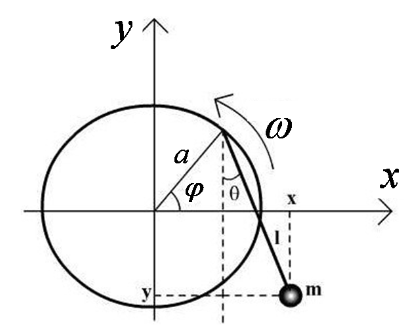

Para este ejercicio nuestra masa tiene 3 coordenadas y dos restricciones, la primera es el eje z=0 y la otra es la restrccion de movimiento al estar unida a una cuerda, esto nos deja 1 grado de libertad, para el cual debemos de solucionar nuestras ecuaciones, así que primero definamos las ecuaciones para nuestro sistema, teniendo en cuenta que el punto de agarre de la varilla esta constantemente moviendose a una velocidad angular constante por tanto ese punto de agarre esta en las posiciones x, y:

$$x_a = a cos(\varphi)$$
$$y_a = a sin(\varphi)$$

Así entonces la posición de la masa en el tiempo esta dada por:
$$x = l sin(\theta) + a cos(\varphi)$$ 
$$y = a sin(\varphi) - l cos(\theta)$$

tomando sus derivadas respecto al tiempo:
$$\dot{x} = l cos(\theta)\dot{\theta} - a sin(\varphi) \dot{\varphi}$$ 
$$\dot{y} = a cos(\varphi)\dot{\varphi} + l sin(\theta)$$



In [487]:
## Definamos las ecuaciones para nuestro sistema

# Definiendo los simbolos  de nuestro problema:
a, l, m, g =  symbols('a l m g')

# Variables dependientes de tiempo
t = symbols('t')  # Símbolo para el tiempo
theta = Function('theta')(t)
phi = Function('phi')(t)
w = Function('w')(t)
# Ahora la posición de la masa teniendo en cuenta el movimiento del punto de agarre
x = Function('x')(t)
y = Function('y')(t)

# Armemos las ecuaciones
x_m = l*sin(theta) + a*cos(phi)
y_m = a*sin(phi) - l*cos(theta) # El menos es debido a la direccion de los ejes

xm_equation = Eq(x, x_m)
ym_equation = Eq(y, y_m)

# Mostremos nuestras ecuaciones
display(xm_equation, ym_equation)

Eq(x(t), a*cos(phi(t)) + l*sin(theta(t)))

Eq(y(t), a*sin(phi(t)) - l*cos(theta(t)))

In [488]:
t = symbols('t')  # Símbolo para el tiempo
theta = symbols('theta')
# Lista de ecuaciones de transformación para cada partícula
transform_equations_per_particle = [
    {
        'mass': m, # Masa de la primera particula
        'x': x_m,  # Ecuaciones de transformación de coordenadas
        'y': y_m,
        'q': [theta], # Variables generalizadas
    }
]

# Calcular la función de energía cinética del sistema
T_total = kinetic_energy(transform_equations_per_particle)

# Imprimir la energía cinética
T = symbols('T') # Asignandole un simbolo a la energía cinética
Ttotal_equation = Eq(T, T_total)
print('Ecuación de energía cinética del sistema:')
display(Ttotal_equation)

Ecuación de energía cinética del sistema:


Eq(T, m*(a**2*Derivative(phi(t), t)**2 - 2*a*l*sin(phi(t) - theta(t))*Derivative(phi(t), t)*Derivative(theta(t), t) + l**2*Derivative(theta(t), t)**2)/2)

In [489]:
# Ugen
# Definir el símbolo para la energía potencial generalizada
Ugen = symbols("Ugen")

# Calcular la energía potencial como la suma de las energías potenciales gravitacionales de las dos masas
potential_function = Eq(Ugen,
simplify(m*g*y_m))

# Mostrar la ecuación de la energía potencial
display(potential_function)

Eq(Ugen, g*m*(a*sin(phi(t)) - l*cos(theta(t))))

Encontrando el lagrangiano

In [490]:
# Definir el símbolo del Lagrangiano
L = symbols('L')

# Calcular el Lagrangiano como la diferencia entre la función energía cinética
# y la función de energía potencial generalizada
Lagrangiano = simplify(Ttotal_equation.rhs - potential_function.rhs)

# Crear la ecuación del Lagrangiano
Lagrangiano_equation = Eq(L, Lagrangiano)

# Mostrar la ecuación del Lagrangiano
display(Lagrangiano_equation)

Eq(L, m*(a**2*Derivative(phi(t), t)**2 - 2*a*l*sin(phi(t) - theta(t))*Derivative(phi(t), t)*Derivative(theta(t), t) - 2*g*(a*sin(phi(t)) - l*cos(theta(t))) + l**2*Derivative(theta(t), t)**2)/2)

In [491]:
theta = Function('theta')(t)

# Calcular las ecuaciones de Euler-Lagrange
Euler_Lagrange_equations = Q_k_from_T_total(Lagrangiano, [theta])

# Imprimir los resultados
equation_E_L_1 = Eq(0, Euler_Lagrange_equations[0])

# Mostrar los resultados de las ecuaciones de Euler-Lagrange
display(equation_E_L_1)

Eq(0, l*m*(-a*sin(phi(t) - theta(t))*Derivative(phi(t), (t, 2)) - a*cos(phi(t) - theta(t))*Derivative(phi(t), t)**2 + g*sin(theta(t)) + l*Derivative(theta(t), (t, 2))))

---

In [492]:

# Calcular las ecuaciones de Euler-Lagrange
Euler_Lagrange_equations = Q_k_from_T_total(Lagrangiano, [theta])

d2_theta =  solve(Euler_Lagrange_equations[0], Derivative(theta, t, 2))[0]
# Reempazando w
d2_theta_w = simplify(d2_theta.subs(
    {Derivative(theta, t): w,
    Derivative(phi, t, 2): 0}))

display(d2_theta_w)
# Llevando esto a una función de python
d2_theta_w_function = lambdify((theta, w, a, l, m, g, phi, Derivative(phi, t)), d2_theta_w)

(a*cos(phi(t) - theta(t))*Derivative(phi(t), t)**2 - g*sin(theta(t)))/l

In [493]:
# Función de pyhton con nuestra ED
def ddot_theta(a, l, m, g, theta, phi, dotphi, w):
    ddot_theta_ = (a*dotphi*w**2*np.cos(theta-phi) -a*dotphi*np.cos(theta - phi)*(w-dotphi) - g*w*np.sin(theta))/l
    #ddot_theta_ = (a* dotphi**2 * np.cos(phi-theta) - g*np.sin(theta))/l
    return ddot_theta_

In [494]:
def system(y, t, a, l, m, g, dotphi):

    # Condicions iniciales
    theta, w  = y 
    
    # Obteniendo a phi de la dotphi
    phi = dotphi*t
    # Evaluar las funciones numéricas
    ddot_theta_ = ddot_theta(a, l, m, g, theta, phi, dotphi, w)
    
    # Las derivadas de theta es simplemente w
    dtheta_dt = w

    # Retornando los valores númericos obtenidos en el formato que odeint requiere
    return [ddot_theta_, dtheta_dt]

In [495]:

# Parámetros del sistema
a, l, m, dotphi, g = 1, 1, 1, 1, 9.8  

# Condiciones iniciales
y0 = [np.pi/4, 0]  

# Array de tiempo para la integración
numero_puntos = 100
t_integrate = np.linspace(0, 1, numero_puntos)  

# Integración con odeint
solution = odeint(system,
                   y0, t_integrate, args=(a, l, m, dotphi, g))

In [496]:
# Creando la figura
fig = plt.figure()

# Inicializar la cámara para capturar cada cuadro de la animación
camera = Camera(fig)

# Establecer que los ejes X y Y tengan la misma escala
plt.axis('equal')

# Agregando un titulo a nuestra figura
plt.title('''Simulación del movimiento del péndulo 
    Formalismo Lagrangiano''', fontweight='bold')

# Haciendo un ciclo para obtener cada captura
for i, t in zip(range(0, numero_puntos), t_integrate):
    # veamos en que valor va phi
    phi = dotphi * t

    # Calcula las posiciones (x, y) para la masa 
    x = l*np.sin(solution[i, 0]) + a*np.cos(phi)
    y = a*np.sin(phi) - l*np.cos(solution[i, 0])

    # Agreguemos la posición del circulo para dibujar a la varilla
    x_c = a*np.cos(phi)
    y_c = a*np.sin(phi)
    

    # Dibujando las masas junto con sus estelas
    plt.plot([x_c, x], [y_c, y], 'k-')  # Varilla del origen a la masa 1
    plt.plot(x, y, 'ro')  


    camera.snap()  # Tomando capturas de cada instante de la gráfica

# Para que no quede un gráfico en blanco para la salida, cerramos la figura
plt.close(fig)

# Animación con intervalo de 50 milisegundos entre cuadros
anim = camera.animate(interval=100)

# Mostrar animación en formato HTML
HTML(anim.to_html5_video())

---

Con estas expresiones ya podemos encontrar nuestra función de energía cinética, con la función que encuentra la energía cinética a partir de la ecuacion de transformación:

In [497]:
Lagrangiano = Rational(1, 2)*m *( l**2*Derivative(theta, t)**2 + a**2*Derivative(phi,t)**2 + 2*a*l*Derivative(phi,t)*Derivative(theta,t)*sin(theta-phi))- m*g*(a*sin(phi)-l*cos(theta))
Lagrangiano

ValueError: 
Can't calculate derivative wrt 1.00000000000000.

In [ ]:


# Calcular las ecuaciones de Euler-Lagrange
Euler_Lagrange_equations = Q_k_from_T_total(Lagrangiano, [theta])

Euler_Lagrange_equations[0]

l*m*(-a*sin(phi(t) - theta(t))*Derivative(phi(t), (t, 2)) - a*cos(phi(t) - theta(t))*Derivative(phi(t), t)**2 + g*sin(theta(t)) + l*Derivative(theta(t), (t, 2)))

**4. Péndulo doble I.** El péndulo doble, como se muestra en la figura, está formado por dos péndulos simples de longitudes $l_1$ y $l_2$, de los que cuelgan partículas de masas $m_1$ y $m_2$.  En un instante determinado $t$, los hilos inextensibles forman ángulos $θ_1$ y $θ_2$ con la vertical.

**a.** Encuentre las ecuaciones de movimiento utilizando el formalismo lagrangiano.

**b.** Solucione numéricamente las ecuaciones del péndulo doble y grafique su movimiento en el espacio de configuración. Luego, estudie el caos en éste sistema, es decir, grafique simultáneamente dos pendulos dobles que arranquen de condiciones iniciales muy cercanas, de modo que se vea que divergen con el tiempo (Ejemplo: https://images.app.goo.gl/TyiUFQb6DaMpKSvAA).

**Reto [opcional].** Realice el mismo procedimiento para el caso de 3 péndulos y luego generalice para $n$ péndulos.

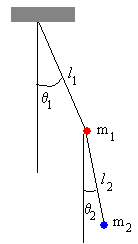

Primero encontremos nuestra función de energía cinética

In [527]:
# Definir las variables generalizadas
theta1, theta2 = symbols('theta1 theta2')
m1, m2, L1, L2, g = symbols('m1 m2 L1 L2 g')

# Lista de ecuaciones de transformación para cada partícula
transform_equations_per_particle = [
    {
        'mass': m1, # Masa de la primera particula
        'x': L1 * sin(theta1),  # Ecuaciones de transformación de coordenadas
        'y': L1 * cos(theta1),
        'q': [theta1], # Variables generalizadas
    },
    {
        'mass': m2,  # Masa de la segunda particula
        
        # Ecuaciones de transformación de coordenadas
        'x': L1 * sin(theta1) + L2 * sin(theta2), 
        'y': L1 * cos(theta1) + L2 * cos(theta2),

        'q': [theta1, theta2], # Variables generalizadas
    }
]

# Calcular la función de energía cinética del sistema
T_total = kinetic_energy(transform_equations_per_particle)

# Imprimir la energía cinética
T = symbols('T') # Asignandole un simbolo a la energía cinética
Ttotal_equation = Eq(T, T_total)
print('Ecuación de energía cinética del sistema:')
display(Ttotal_equation)

Ecuación de energía cinética del sistema:


Eq(T, L1**2*m1*Derivative(theta1(t), t)**2/2 + m2*(L1**2*Derivative(theta1(t), t)**2 + 2*L1*L2*cos(theta1(t) - theta2(t))*Derivative(theta1(t), t)*Derivative(theta2(t), t) + L2**2*Derivative(theta2(t), t)**2)/2)

Ahora definamos nuestra Ugen, sabiendo que la fuerza del problema es una fuerza conservativa

In [528]:
# Definir el símbolo para el tiempo y las variables generalizadas theta1 y theta2
t = symbols('t')
theta1 = Function('theta1')(t)
theta2 = Function('theta2')(t)
# Definir el símbolo para la energía potencial generalizada
Ugen = symbols("Ugen")

# Calcular la energía potencial como la suma de las energías potenciales gravitacionales de las dos masas
potential_function = Eq(Ugen,
simplify(-(m1 * g * L1 * cos(theta1) + m2 * g * (L1 * cos(theta1) + L2 * cos(theta2)))))

# Mostrar la ecuación de la energía potencial
display(potential_function)

Eq(Ugen, -g*(L1*m1*cos(theta1(t)) + L1*m2*cos(theta1(t)) + L2*m2*cos(theta2(t))))

ya con estos dos elementos podemos construir el larangiano del sistema

In [529]:
# Definir el símbolo del Lagrangiano
L = symbols('L')

# Calcular el Lagrangiano como la diferencia entre la función energía cinética
# y la función de energía potencial generalizada
Lagrangiano = simplify(Ttotal_equation.rhs - potential_function.rhs)

# Crear la ecuación del Lagrangiano
Lagrangiano_equation = Eq(L, Lagrangiano)

# Mostrar la ecuación del Lagrangiano
display(Lagrangiano_equation)

Eq(L, L1**2*m1*Derivative(theta1(t), t)**2/2 + g*(L1*m1*cos(theta1(t)) + L1*m2*cos(theta1(t)) + L2*m2*cos(theta2(t))) + m2*(L1**2*Derivative(theta1(t), t)**2 + 2*L1*L2*cos(theta1(t) - theta2(t))*Derivative(theta1(t), t)*Derivative(theta2(t), t) + L2**2*Derivative(theta2(t), t)**2)/2)

Para encontrar las ecuaciones diferenciales podemos usar las ecuaciones de euler-lagrange
$$\left\{ \frac{d}{dt} \left( \frac{\partial L}{\partial \dot{q}_j} \right) - \frac{\partial L}{\partial q_j} = 0 \right\}_M$$

In [530]:
# Definir el símbolo para el tiempo y las variables generalizadas theta1 y theta2
t = symbols('t')
theta1 = Function('theta1')(t)
theta2 = Function('theta2')(t)

# Calcular las ecuaciones de Euler-Lagrange
Euler_Lagrange_equations = Euler_lagrange(Lagrangiano, [theta1, theta2])

# Imprimir los resultados
equation_E_L_1 = Eq(0, Euler_Lagrange_equations[0])
equation_E_L_2 = Eq(0, Euler_Lagrange_equations[1])

# Mostrar los resultados de las ecuaciones de Euler-Lagrange
display(equation_E_L_1, equation_E_L_2)

Eq(0, L1*(L1*m1*Derivative(theta1(t), (t, 2)) + L1*m2*Derivative(theta1(t), (t, 2)) + L2*m2*sin(theta1(t) - theta2(t))*Derivative(theta2(t), t)**2 + L2*m2*cos(theta1(t) - theta2(t))*Derivative(theta2(t), (t, 2)) + g*m1*sin(theta1(t)) + g*m2*sin(theta1(t))))

Eq(0, L2*m2*(-L1*sin(theta1(t) - theta2(t))*Derivative(theta1(t), t)**2 + L1*cos(theta1(t) - theta2(t))*Derivative(theta1(t), (t, 2)) + L2*Derivative(theta2(t), (t, 2)) + g*sin(theta2(t))))

A partir de estás expresiones de Equler-Lagrange poodemos despejar la aceleracion angular $\ddot{\theta_1} , \ddot{\theta_2} $

In [531]:
# Despejar las aceleraciones angulares usando las ecuaciones de Euler-Lagrange
d2_theta1 = Eq(Derivative(theta1, t, 2),
                  solve(equation_E_L_1, Derivative(theta1, t, 2))[0])

d2_theta2 = Eq(Derivative(theta2, t, 2),
                  solve(equation_E_L_2, Derivative(theta2, t, 2))[0])

# Mostrar los resultados de las aceleraciones angulares
display(d2_theta1, d2_theta2)

Eq(Derivative(theta1(t), (t, 2)), -(L2*m2*sin(theta1(t) - theta2(t))*Derivative(theta2(t), t)**2 + L2*m2*cos(theta1(t) - theta2(t))*Derivative(theta2(t), (t, 2)) + g*m1*sin(theta1(t)) + g*m2*sin(theta1(t)))/(L1*(m1 + m2)))

Eq(Derivative(theta2(t), (t, 2)), (L1*sin(theta1(t) - theta2(t))*Derivative(theta1(t), t)**2 - L1*cos(theta1(t) - theta2(t))*Derivative(theta1(t), (t, 2)) - g*sin(theta2(t)))/L2)

Ahora ya con las ED podemos entrar a solucionarlas númericamente pero para eso debemos hacer unos pasos anteriores:

In [532]:
# Definimos los simbolos de las variables de transformación
w1, w2 = symbols('w1 w2')
# w1 y w2 son funciones del Tiempo
w1, w2 = Function('w1')(t), Function('w2')(t) 

## Establecemos w como d(theta)/dt
omega1_equation = Eq(Derivative(theta1,t), w1)
omega2_equation = Eq(Derivative(theta2,t), w2)


# Ahora reemplazamos omega en nuestras expresiones para la aceleración angular

d2_theta1_w = simplify(d2_theta1.subs(
    {Derivative(theta1, t): w1, # Dtheta1 por w1
    Derivative(theta2, t): w2})) # Dtheta2 por w2

d2_theta2_w = simplify(d2_theta2.subs(
    {Derivative(theta1, t): w1,  # Dtheta1 por w1
    Derivative(theta2, t): w2})) # Dtheta2 por w2

# Mostrando nuestras nuevas expresiones en terminos de w1 y w2
display(omega1_equation, d2_theta1_w, omega2_equation, d2_theta2_w)

Eq(Derivative(theta1(t), t), w1(t))

Eq(Derivative(w1(t), t), -(L2*m2*w2(t)**2*sin(theta1(t) - theta2(t)) + L2*m2*cos(theta1(t) - theta2(t))*Derivative(w2(t), t) + g*m1*sin(theta1(t)) + g*m2*sin(theta1(t)))/(L1*(m1 + m2)))

Eq(Derivative(theta2(t), t), w2(t))

Eq(Derivative(w2(t), t), (L1*w1(t)**2*sin(theta1(t) - theta2(t)) - L1*cos(theta1(t) - theta2(t))*Derivative(w1(t), t) - g*sin(theta2(t)))/L2)

Vamos a desacoplarlas

In [539]:
# Solucionando para dw1 sin dependencia de dw2 y viceversa
desacoplate_solutions = solve((d2_theta1_w, d2_theta2_w),
                            (Derivative(w1, t), Derivative(w2, t)), dict=True)

for sol in desacoplate_solutions:
    d2_theta1_w_ = sol[Derivative(w1, t)]
    d2_theta2_w_ = sol[Derivative(w2, t)]
# Volvemos a establecer las ecuaciones en terminos de los w
d2_theta1_w = simplify(d2_theta1_w_.subs(
    {Derivative(theta1, t): w1, # Dtheta1 por w1
    Derivative(theta2, t): w2})) # Dtheta2 por w2

d2_theta2_w = simplify(d2_theta2_w_.subs(
    {Derivative(theta1, t): w1, # Dtheta1 por w1
    Derivative(theta2, t): w2})) # Dtheta2 por w2

Pasemos nuestras funciones simbolicas a funciones de python

In [541]:
dw1_dt_func = lambdify((theta1,theta2, w1,  w2, g, m1, m2, L1, L2), d2_theta1_w)
dw2_dt_func = lambdify((theta1, theta2, w1,  w2, g,m1, m2,  L1, L2), d2_theta2_w)

Hagamso una función que contenga nuestras cuatro ecuaciones y que este en un formato que me acepte odeint

In [558]:
# Definiendo las ecuaciones diferenciales del péndulo doble
def double_pendulum_derivs(y, t, L1, L2, m1, m2, g):

    # Condicions iniciales
    theta1, w1, theta2, w2 = y 
    
    # Evaluar las funciones numéricas
    domega1_dt = dw1_dt_func(theta1,theta2, w1,  w2, g, m1, m2, L1, L2)
    domega2_dt = dw2_dt_func(theta1, theta2, w1,  w2, g,m1, m2,  L1, L2)
    
    # Las derivadas de theta1 y theta2 son simplemente w1 y w2
    dtheta1_dt = w1
    dtheta2_dt = w2

    # Retornando los valores númericos obtenidos en el formato que odeint requiere
    return [dtheta1_dt, domega1_dt, dtheta2_dt, domega2_dt]

Integremos nuestra solución con odeint

In [559]:
# Parámetros del sistema
L1p, L2p, m1p, m2p, gp = .5, 1, 5, 1, 9.8  
L1, L2, m1, m2, g = L1p, L2p, m1p, m2p, gp 

# Condiciones iniciales
y0 = [np.pi/4, -1, np.pi/4, 2]  

# Array de tiempo para la integración
numero_puntos = 200
t_integrate = np.linspace(0, 3, numero_puntos)  

# Integración con odeint
solution = odeint(double_pendulum_derivs,
                   y0, t_integrate, args=(L1, L2, m1, m2, g))

In [569]:
# Creando la figura
fig = plt.figure()

# Inicializar la cámara para capturar cada cuadro de la animación
camera = Camera(fig)

# Establecer que los ejes X y Y tengan la misma escala
plt.axis('equal')

# Agregando un titulo a nuestra figura
plt.title('''Simulación del movimiento del péndulo doble
    Formalismo Lagrangiano''', fontweight='bold')

# Haciendo un ciclo para obtener cada captura
for i in range(0, numero_puntos):
    # Calcula las posiciones (x, y) para la masa 1
    x1 = L1 * np.sin(solution[i, 0])
    y1 = -L1 * np.cos(solution[i, 0])

    # Agregando una estela para la masa 1
    x_e = L1 * np.sin([solution[j, 0] for j in range(i-19,i) if j >=0])
    y_e = -L1 * np.cos([solution[j, 0] for j in range(i-19,i) if j >=0 ])
    
    # Calcula las posiciones (x, y) para la masa 2
    x2 = L2 * np.sin(solution[i, 2]) + x1
    y2 = -L2 * np.cos(solution[i, 2]) + y1

    # Agregando una estela para la masa 2
    x_e_2 = L2 * np.sin([solution[j, 2] for j in range(i-19,i) if j >=0]) + x_e
    y_e_2 = -L2 * np.cos([solution[j, 2] for j in range(i-19,i) if j >=0 ]) + y_e

    ## Dibujando las varillas 
    plt.plot([0, x1], [0, y1], 'k-')  # Varilla del origen a la masa 1
    plt.plot([x1, x2], [y1, y2], 'k-')  # Varilla de la masa 1 a la masa 2

    # Dibujando las masas junto con sus estelas
    # Masa 1
    plt.plot(x1, y1, 'ro')  
    plt.plot(x_e, y_e, 'ro',  markersize = .5)

    # Masa 2
    plt.plot(x2, y2, 'ro')  
    plt.plot(x_e_2, y_e_2, 'ro',  markersize = .5)

    camera.snap()  # Tomando capturas de cada instante de la gráfica

# Para que no quede un gráfico en blanco para la salida, cerramos la figura
plt.close(fig)

# Animación con intervalo de 50 milisegundos entre cuadros
anim = camera.animate(interval=50)

# Mostrar animación en formato HTML
HTML(anim.to_html5_video())

Ahora hagamos una simulación para dos pendulos al tiempo con carcateristicas muy similares

In [667]:
# Parámetros constantes del problema
L1, L2, m1, m2, g = 1, 1, .4, .4, 10
# Condiciones iniciales
y0 = [np.pi/2, -1, np.pi/2, 2]  
# Cambiando un poco las condiciones iniciales
# Condiciones iniciales
y2 = y0.copy()
y2[1] += .15 # Sumando un delta muy pequeño al w1
y2[3] -= .15 # Sumando un delta muy pequeño al w2

# Definamos un periodo de integración largo
numero_puntos  = 300
t_integrate_caos = np.linspace(0, 20, numero_puntos)

Hagamos la integración para ambas condiciones iniciales

In [668]:
# Solución para el pendulo 1
solution_1 = odeint(double_pendulum_derivs, y0,
                       t_integrate_caos, args=(L1, L2, m1, m2, g))

# Solución para el pendulo 2
solution_2 = odeint(double_pendulum_derivs, y2,
                       t_integrate_caos, args=(L1, L2, m1, m2, g))

Hagamos una simulación del movimiento de los dos pendulos

In [669]:
# Creando la figura
fig = plt.figure()

# Inicializar la cámara para capturar cada cuadro de la animación
camera = Camera(fig)

# Establecer que los ejes X y Y tengan la misma escala
plt.axis('equal')
plt.title('''Simulación del movimiento de 
        dos péndulos dobles con condiciones similares'''
          , fontweight='bold')

# Haciendo un ciclo para cada captura
for i in range(0, numero_puntos):
    ## Gráficando el primer pendulo
    # Calcula las posiciones (x, y) de las masas 
    x1 = L1 * np.sin(solution_1[i, 0])
    y1 = -L1 * np.cos(solution_1[i, 0])

    # Agregando una estela para la masa 1
    x_e = L1 * np.sin([solution_1[j, 0] for j in range(i-19,i) if j >=0])
    y_e = -L1 * np.cos([solution_1[j, 0] for j in range(i-19,i) if j >=0 ])

    # Calcula las posiciones (x, y) para la masa 2
    x2 = L2 * np.sin(solution_1[i, 2]) + x1
    y2 = -L2 * np.cos(solution_1[i, 2]) + y1

    # Agregando una estela para la masa 2
    x_e_2 = L2 * np.sin([solution_1[j, 2] for j in range(i-19,i) if j >=0]) + x_e
    y_e_2 = -L2 * np.cos([solution_1[j, 2] for j in range(i-19,i) if j >=0 ]) + y_e


    ## Dibujando las varillas 
    plt.plot([0, x1], [0, y1], 'k-')  # Varilla del origen a la masa 1
    plt.plot([x1, x2], [y1, y2], 'k-')  # Varilla de la masa 1 a la masa 2

    # Dibujando las masas junto con sus estelas
    # Masa 1
    plt.plot(x1, y1, 'ro')  
    plt.plot(x_e, y_e, 'ro',  markersize = .7)

    # Masa 2
    plt.plot(x2, y2, 'ro')  
    plt.plot(x_e_2, y_e_2, 'ro',  markersize = .7)

    ## Gráficando el segundo pendulo
    # Calcula las posiciones (x, y) de las masas 
    x1_2 = L1 * np.sin(solution_2[i, 0])
    y1_2 = -L1 * np.cos(solution_2[i, 0])

    # Agregando una estela para la masa 1
    x_e_2 = L1 * np.sin([solution_2[j, 0] for j in range(i-19,i) if j >=0])
    y_e_2 = -L1 * np.cos([solution_2[j, 0] for j in range(i-19,i) if j >=0 ])

    # Calcula las posiciones (x, y) para la masa 2
    x2 = L2 * np.sin(solution_2[i, 2]) + x1_2
    y2 = -L2 * np.cos(solution_2[i, 2]) + y1_2

    # Agregando una estela para la masa 2
    x_e_2_2 = L2 * np.sin([solution_2[j, 2] for j in range(i-19,i) if j >=0]) + x_e_2
    y_e_2_2 = -L2 * np.cos([solution_2[j, 2] for j in range(i-19,i) if j >=0 ]) + y_e_2


    ## Dibujando las varillas 
    plt.plot([0, x1_2], [0, y1_2], 'k-')  # Varilla del origen a la masa 1
    plt.plot([x1_2, x2], [y1_2, y2], 'k-')  # Varilla de la masa 1 a la masa 2

    # Dibujando las masas junto con sus estelas
    # Masa 1
    plt.plot(x1_2, y1_2, 'bo')  
    plt.plot(x_e_2, y_e_2, 'bo',  markersize = .7)

    # Masa 2
    plt.plot(x2, y2, 'bo')  
    plt.plot(x_e_2_2, y_e_2_2, 'bo',  markersize = .7)


    camera.snap()  # Tomando capturas de cada instante de la gráfica

# Para que no quede un gráfico en blanco para la salida
plt.close(fig)

# Animación con intervalo de 150 milisegundos entre cuadros
anim = camera.animate(interval = 80)

# Mostrar animación en formato HTML
HTML(anim.to_html5_video())

**5. Péndulo móvil.** Una masa $m_1$ se desliza de forma horizontal y sin fricción sobre un soporte de masa despreciable. Una segunda masa $m_2$ está atada a $m_1$ por medio de una cuerda de longitud $l$ y masa despreciable
(ver figura). Encuentre las ecuaciones de movimiento del sistema, utilizando el formalismo Lagrangiano. Solucione numéricamente y grafique (simule) el movimiento del péndulo.

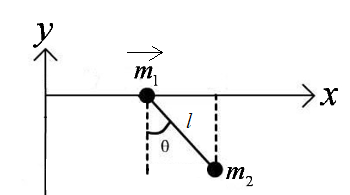

 **6. El CRTBP coplanar.** Una partícula de prueba de masa $m$ se mueve sobre el plano de Laplace de otros dos cuerpos de masas ($1 - \alpha$) y $\alpha$ las cuales son mucho mayores que $m$ y determinan su dinámica. En este caso, el Hamiltoniano se escribe como

 $$
 H = \frac{p_x^2}{2m} + \frac{p_y^2}{2m} + p_x y' - p_y x' - (1-\alpha)\frac{m}{r_1} - \alpha\frac{m}{r_2}
 $$

 con $r_1 = \sqrt{(x' + \alpha)^2 + y'^2}$ y $r_2 = \sqrt{[x' - (1- \alpha)]^2 + y'^2}$ . Las variables primadas están referidas a un sistema que rota con velocidad angular constante igual a la unidad.

 Encuentre las ecuaciones Hamiltonianas de movimiento para este sistema.

 **7. Partícula deslizándose sobre un alambre parabólico.** Una partícula de masa $m$ se desliza bajo la acción de la gravedad y sin fricción sobre un alambre con forma de parábola.

**a.** Demuestre que el Hamiltoniano de este sistema se escribe como

\begin{equation}
  H(x,p) = \frac{p^2}{2m(1+x^2)} + \frac{mg}{2}x^2
\end{equation}


**b.** Grafique e interprete los contornos de nivel para este Hamiltoniano.


**8. El Hamiltoniano de Hénon-Heiles.** En 1964, M. Hénon y C.Heiles estudiaban el movimiento de las estrellas alrededor del centro galáctico tratando de encontrar una tercera constante de movimiento a parte del momentum angular y la energía. Esto les llevo a proponer un potencial idealizado que restringía su acción solo al plano x, y. Este potencial se caracteriza por poseer dos términos cúbicos que involucran a las variables x, y haciendo a las ecuaciones de movimiento resultantes no lineales y acopladas. El Hamiltoniano asociado es el Hamiltoniano de Hénon-Heiles que en coordenadas cartesianas se escribe como

\begin{equation}
 H = \frac{p_x^2}{2m} + \frac{p_y^2}{2m} + \frac{1}{2}(x^2+y^2) + x^2y - \frac{1}{3}y^3
\end{equation}

**a.** ¿El Hamiltoniano de Hénon-Heiles coincide con la energía?

**b.** Deduzca las ecuaciones Hamiltonianas de movimiento para una masa m sometida a este potencial. Tenga en cuenta que $p_x = m\dot{x}$ y $p_y = m\dot{y}$.

**c.** Para un par de condiciones iniciales apropiadas (fije un valor de la energía y encuentre valores de las variables generalizadas que la satisfagan) integre numéricamente las ecuaciones de movimiento usando el método de Euler y el integrador simpléctico Leap-Frog (Consultar). Grafique el comportamiento de la energía como función del tiempo ¿Es la energía una cantidad conservada con ambos esquemas?

**d.** Grafique la trayectoria en el espacio de configuración.

**e.** Grafique los contornos de nivel del potencial para distintos valores de la energía (E = $1/6$, $1/8$, $1/12$, $1/24$, $0,01$) y relacione los resultados con el inciso anterior.

**SOLUCIÓN**

**a.** ¿El Hamiltoniano de Hénon-Heiles coincide con la energía?

Si ya que el Hamiltoniano coincide con la energía siempre y cuando no haya una dependencia explicita con el tiempo

**b.** Deduzca las ecuaciones Hamiltonianas de movimiento para una masa m sometida a este potencial. Tenga en cuenta que $p_x = m\dot{x}$ y $p_y = m\dot{y}$.

In [670]:
# Expresemos este Hamiltoniano con sympy
H, m, t = symbols('H m t')

# Las variables dependientes del tiempo
x = Function('x')(t)
y = Function('y')(t)
px = Function('px')(t)
py = Function('py')(t)

Hamiltoniano =  px**2/(2*m) + py**2/(2*m) + Rational(1, 2)*(x**2 + y**2) + x**2*y-\
                Rational(1, 3)*y**3

# Hagamos una ecuación para nuestro hamiltoniano
Hamiltoniano_equation = Eq(H, Hamiltoniano)

# Imprimamos nuestros resultados
display(Hamiltoniano_equation)

Eq(H, x(t)**2*y(t) + x(t)**2/2 - y(t)**3/3 + y(t)**2/2 + px(t)**2/(2*m) + py(t)**2/(2*m))

Usemos las ecuaciones canonicas para el Hamiltoniano:
\begin{equation}
\begin{cases}
\dot{q}_j = +\frac{\partial H}{\partial p_j} & M \\
\dot{p}_j = -\frac{\partial H}{\partial q_j} & M
\end{cases}
\end{equation}

Definamos algunas funciones: Una que que encuentre $\dot{q}_j$ a partir de H al igual para $\dot{p}_j$

In [671]:
# Defininedo la función para qj
dotqj_function = lambda H, pj: [simplify(H.diff(i)) for i in pj]

# Definiendo la función para pj punto 
dotpj_function = lambda H, qj: [-simplify(H.diff(i)) for i in qj]

In [672]:
# Usemos estas funciones para hallar nuestros dotqj y dotpj
dotqj = dotqj_function(Hamiltoniano, [px, py])
dotpj = dotpj_function(Hamiltoniano, [x, y])

## Ahora veamos estas expresiones en sus ecuaciones correspondientes
# Para los q punto 
dotq1_equation = Eq(Derivative(x, t ), dotqj[0])
dotq2_equation = Eq(Derivative(y, t ), dotqj[1])

# Para los p punto
dotp1_equation = Eq(Derivative(px, t ), dotpj[0])
dotp2_equation = Eq(Derivative(py, t ), dotpj[1])

# Mostrando los resultados 
display(dotq1_equation, dotq2_equation, dotp1_equation, dotp2_equation)

Eq(Derivative(x(t), t), px(t)/m)

Eq(Derivative(y(t), t), py(t)/m)

Eq(Derivative(px(t), t), -(2*y(t) + 1)*x(t))

Eq(Derivative(py(t), t), -x(t)**2 + y(t)**2 - y(t))

Estas son las ecuaciones hamiltonianas del movimiento

**c.** Para un par de condiciones iniciales apropiadas (fije un valor de la energía y encuentre valores de las variables generalizadas que la satisfagan) integre numéricamente las ecuaciones de movimiento usando el método de Euler y el integrador simpléctico Leap-Frog (Consultar). Grafique el comportamiento de la energía como función del tiempo ¿Es la energía una cantidad conservada con ambos esquemas?

Asignemos el Hamiltoniano a una función de python para poder ser evauado númericamente

In [673]:
def H(x, y, px, py):
    H_value = px**2/(2*m) + py**2/(2*m) + (x**2 + y**2)/2 + x**2*y-y**3/3
    return H_value

Solucionando el sistema con Leap-Frog

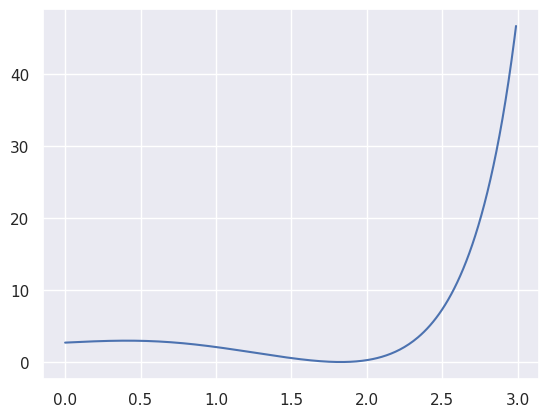

In [674]:
# Define las ecuaciones de movimiento
def dx_dt(px, m):
    return px / m

def dy_dt(py, m):
    return py / m

def dpx_dt(x, y):
    return -2 * y * x + y**2 - x

def dpy_dt(x, y):
    return -x**2 + y**2 - y

# Condiciones iniciales
x = 1
y = 1
px = 1
py = 1
m = 1 # La masa del objeto
dt = 0.01 # El paso de tiempo

# Arrays para guardar los resultados
x_values = [x]
y_values = [y]
px_values = [px]
py_values = [py]

# Tiempo de integración
t_integrate = np.arange(0, 3, dt)
# Loop de integración
for t in t_integrate:
    # Actualiza momentos a la mitad del paso de tiempo
    px_half = px + 0.5 * dt * dpx_dt(x, y)
    py_half = py + 0.5 * dt * dpy_dt(x, y)
    
    # Actualiza posiciones con el momento medio
    x += dt * dx_dt(px_half, m)
    y += dt * dy_dt(py_half, m)
    
    # Actualiza momentos al final del paso de tiempo
    px = px_half + 0.5 * dt * dpx_dt(x, y)
    py = py_half + 0.5 * dt * dpy_dt(x, y)
    
    # Guarda los valores
    x_values.append(x)
    y_values.append(y)
    px_values.append(px)
    py_values.append(py)

# Ahora veamos el valor de H con las soluciones obtenidas
H_values = []
for i, t in enumerate(t_integrate):
    H_values.append(H(x_values[i], y_values[i], px_values[i], py_values[i]))

# Graficando a H en el tiempo
plt.plot(t_integrate, H_values)

Ahora con Euler

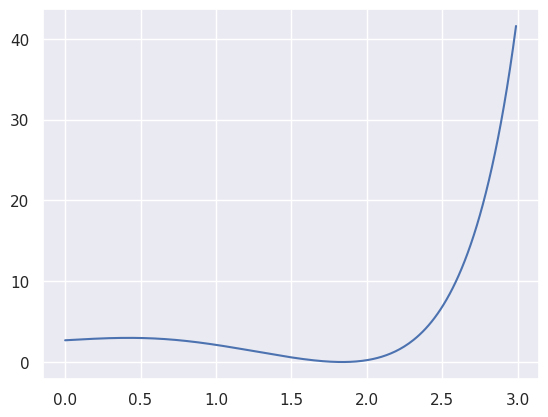

In [675]:
import numpy as np
import matplotlib.pyplot as plt

# Define las ecuaciones de movimiento
def dx_dt(px, m):
    return px / m

def dy_dt(py, m):
    return py / m

def dpx_dt(x, y):
    return -2 * y * x + y**2 - x

def dpy_dt(x, y):
    return -x**2 + y**2 - y

# Condiciones iniciales
x = 1
y = 1
px = 1
py = 1
m = 1 # La masa del objeto
dt = 0.01 # El paso de tiempo

# Arrays para guardar los resultados
x_values = [x]
y_values = [y]
px_values = [px]
py_values = [py]

t_integrate = np.arange(0, 3, dt)
# Loop de integración usando el método de Euler
for t in t_integrate:
    # Calcula las derivadas de las posiciones y los momentos
    x_deriv = dx_dt(px, m)
    y_deriv = dy_dt(py, m)
    px_deriv = dpx_dt(x, y)
    py_deriv = dpy_dt(x, y)
    
    # Actualiza las posiciones y los momentos usando las derivadas
    x += dt * x_deriv
    y += dt * y_deriv
    px += dt * px_deriv
    py += dt * py_deriv
    
    # Guarda los valores
    x_values.append(x)
    y_values.append(y)
    px_values.append(px)
    py_values.append(py)

# Ahora veamos el valor de H con las soluciones obtenidas
H_values = []
for i, t in enumerate(t_integrate):
    H_values.append(H(x_values[i], y_values[i], px_values[i], py_values[i]))

# Graficando a H en el tiempo
plt.plot(t_integrate, H_values)


**d.** Grafique la trayectoria en el espacio de configuración.

Usando la solución obtenida del punto anterior

Text(0, 0.5, 'y')

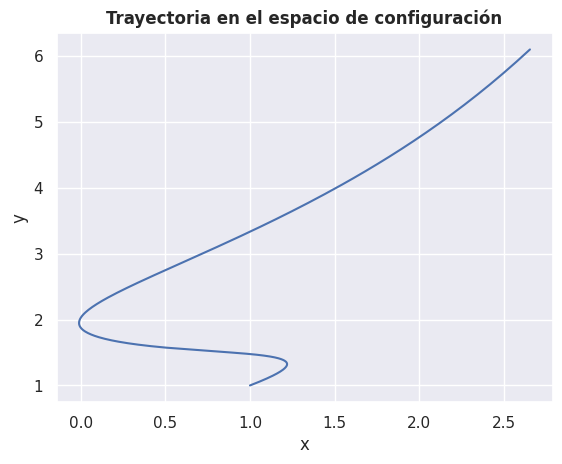

In [676]:
plt.title('Trayectoria en el espacio de configuración', fontweight = 'bold')
plt.plot(x_values, y_values)
plt.xlabel('x')
plt.ylabel('y')


**e.** Grafique los contornos de nivel del potencial para distintos valores de la energía (E = $1/6$, $1/8$, $1/12$, $1/24$, $0,01$) y relacione los resultados con el inciso anterior.

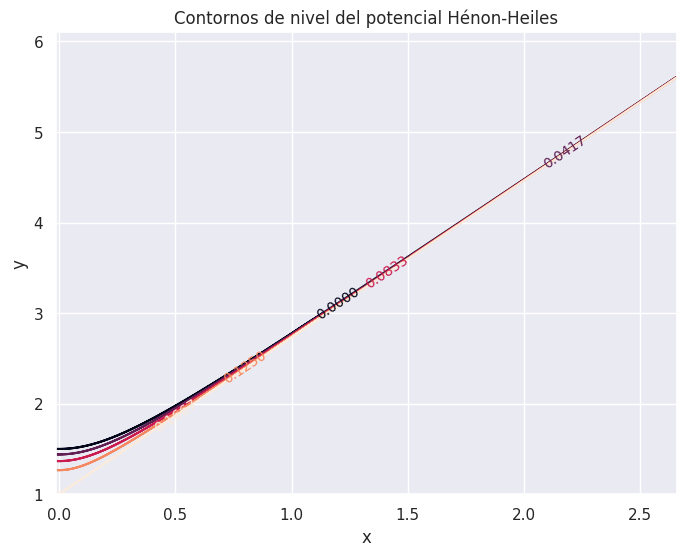

In [677]:
import numpy as np
import matplotlib.pyplot as plt

# Definimos el potencial V(x, y) del sistema Hénon-Heiles
def V(x, y):
    return 0.5 * (x**2 + y**2) + x**2 * y - (y**3) / 3



# Creamos una malla de puntos para x y y
X, Y = np.meshgrid(x_values, y_values)

# Calculamos los valores del potencial en la malla
Z = V(X, Y)

# Valores de energía para los contornos de nivel
energy_levels = [1/6, 1/8, 1/12, 1/24, 0]
energy_levels.reverse()

# Graficamos los contornos de nivel
plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, Z, levels=energy_levels)
plt.xlabel('x')
plt.ylabel('y')
plt.clabel(contour, inline=1, fontsize=10)
plt.title('Contornos de nivel del potencial Hénon-Heiles')
plt.grid(True)
plt.show()


---

**9. Mecánica generalizada.** El término _mecánica generalizada_ se usa para designar una variación de la mecánica clásica en la que el Lagrangiano contiene derivadas temporales de $q_i$ más allá de primer orden. Problemas en los que $x = f(x,\dot{x},\ddot{x},t)$ han sido nombrados en inglés como _"jerky mechanics"_. Tales ecuaciones de movimiento tienen interesantes aplicaciones en teoría de caos (las cuales no trabajaremos).

Aplicando los métodos del cálculo de variaciones, muestre que si hay un lagrangiano de la forma $L(q_i,\dot{q}_i,\ddot{q}_i,t)$, y el principio de Hamilton permanece con la invarianza de $q_i$ y $\dot{q}_i$ en los extremos, entonces las ecuaciones de Euler-Lagrange correspondientes son:

\begin{equation}
\frac{d^2}{dt^2}\Big(\frac{\partial L}{\partial \ddot{q_i}}\Big) - \frac{d}{dt}\Big(\frac{\partial L}{\partial \dot{q_i}}\Big) + \frac{\partial L}{\partial q_i} = 0. \qquad i = 1,2,... ,n.
\end{equation}

Aplique el resultado al Lagrangiano:

\begin{equation}
L = -\frac{m}{2}q\ddot{q} - \frac{k}{2}q^2
\end{equation}

¿Reconoce las ecuaciones de movimiento encontradas?

Para la realización de la demostración vamos a usar el principio de minima acción, así que definamos la acción:

$$S = \int_{t_1}^{t_2} L(q, \dot{q}, \ddot{q},t)dt$$

veamos un delta de la acción:
$$\delta S = \int_{t_1}^{t_2} \delta L(q, \dot{q}, \ddot{q},t)dt$$

usando la regla de la cadena podemos encontrar que:

$$\delta S = \int_{t_1}^{t_2} \frac{\partial L}{\partial q} \delta q +
                            \frac{\partial L}{\partial \dot{q}} \delta \dot{q} +
                            \frac{\partial L}{\partial \ddot{q}} \delta \ddot{q} dt
$$


Ahora analicemos algunos terminos por separado:
$$
\frac{\partial L}{\partial \dot{q}} \delta \dot{q}= 
                    \frac{d}{dt}(\frac{\partial L}{\partial \dot{q}}  \delta_{\dot q})
                    -\frac{d}{dt}\frac{\partial L}{\partial \dot{q}} \delta_q
$$

$$
\frac{\partial L}{\partial \ddot{q}} \delta \ddot{q} dt =
\frac{\partial L}{\partial \ddot{q}}\frac{d}{dt} \delta_{\dot q} = 
\frac{d}{dt}(\frac{\partial L}{\partial \ddot{q}}\frac{d}{dt} \delta_q) -
\frac{d}{dt}\frac{\partial L}{\partial \ddot{q}}\frac{d}{dt} \delta_q
$$            

reemplazando en la integral:

$$
\delta S = \int_{t_1}^{t_2} \frac{\partial L}{\partial q} \delta q +
\frac{d}{dt}(\frac{\partial L}{\partial \dot{q}}  \delta_{\dot q})
-\frac{d}{dt}\frac{\partial L}{\partial \dot{q}} \delta_q +
\frac{\partial L}{\partial \ddot{q}}\frac{d}{dt} \delta_{\dot q} = 
\frac{d}{dt}(\frac{\partial L}{\partial \ddot{q}}\frac{d}{dt} \delta_q) -
\frac{d}{dt}\frac{\partial L}{\partial \ddot{q}}\frac{d}{dt} \delta_q
$$

Sepandola en una suma de integrales
$$
\delta S = \int_{t_1}^{t_2} \frac{\partial L}{\partial q} \delta q +
 \int_{t_1}^{t_2} (\frac{\partial L}{\partial q}-\frac{d}{dt}\frac{\partial L}{\partial \dot{q}}) \delta_q dt + 
 \int_{t_1}^{t_2} \frac{\partial L}{\partial \dot{q}}\delta_q -
\int_{t_1}^{t_2} \frac{d}{dt}\frac{\partial L}{\partial \ddot{q}}\frac{d}{dt} \delta_q dt
$$

La primera y la tercera integral son cero al no tener una dependencia con el tiempo, ahora para la ultima integral de nuestra expresión debemos tener en cuenta que:

$$
\frac{d}{dt}\frac{\partial L}{\partial \ddot{q}}\frac{d}{dt} \delta_q = 
\frac{d}{dt}(\frac{d}{dt}\frac{\partial L}{\partial \ddot{q}}\delta_{\dot{q}} )-
\frac{d^2}{dt^2}\frac{\partial L}{\partial \ddot{q}} \delta_q
$$

uniendo las integrales restantes y reemplazando este termino, podemos obetener que:
$$
\delta S = \int_{t_1}^{t_2} (\frac{\partial L}{\partial q}-\frac{d}{dt}\frac{\partial L}{\partial \dot{q}} + \frac{d^2}{dt^2}\frac{\partial L}{\partial \ddot{q}} ) \delta_q dt -
\int_{t_1}^{t_2} \frac{d}{dt}(\frac{d}{dt}\frac{\partial L}{\partial \ddot{q}}\delta_{\dot{q}} )
$$

Nuestra segunda integral es cero, ya que la variaación es cero en los extremos:

Ahora minimizamos la acción así que $\delta S = 0$, dejandonos que:

$$
\frac{d^2}{dt^2}\frac{\partial L}{\partial \ddot{q}} 
-\frac{d}{dt}\frac{\partial L}{\partial \dot{q}} + \frac{\partial L}{\partial q}  = 0
$$

y esto es justo lo que buscamos demostrar

Ahora apliquemos esto para nuestro lagragiano específico:
$$
L = -\frac{m}{2}q\ddot{q} - \frac{k}{2}q^2
$$
Hagamoslo por pasos y después unimos las partes
$$
\frac{\partial L}{\partial \ddot{q}} = 
-\frac{m}{2}q
$$

$$
\frac{d^2}{dt^2}\frac{\partial L}{\partial \ddot{q}} =
-\frac{m}{2}\ddot{q}
$$

$$
\frac{\partial L}{\partial \dot{q}} = 0
= \frac{d}{dt}\frac{\partial L}{\partial \dot{q}} 
$$

$$
\frac{\partial L}{\partial q} = -\frac{m}{2}\ddot{q} - kq
$$

Como:
$$
\frac{d^2}{dt^2}\frac{\partial L}{\partial \ddot{q}} 
-\frac{d}{dt}\frac{\partial L}{\partial \dot{q}} + \frac{\partial L}{\partial q}  = 0
$$

reemplazando nuestras expresiones nos queda como:
$$
-\frac{m}{2}\ddot{q} -\frac{m}{2}\ddot{q} - kq = 0
$$

$$
m \ddot{q} + kq = 0
$$

si $\frac{k}{m} = w$, entonces:

$$
 \ddot{q} + wq = 0
$$

Esta expresión correponde a la ED que describe el movimiento de un oscilador armonico simple

reem